# Training und Verifikation mittels MILP von Netz auf CIFAR10 Datensatz
Es sollte bereits ein trainiertes Netz existieren.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from script.Networks import *
from script.trainFunction import train_sequential
from script.Verification import verification_of_normal
import time
from jupyterthemes import jtplot

load_model = True
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)



In [2]:
transform = Compose([ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                    )

training_data = CIFAR10(root="../../cifar",
                        train=True,
                        download=True,
                        transform=transform)

test_data = CIFAR10(root="../../cifar",
                    train=False,  # test set, 10k images
                    download=True,
                    transform=transform)

batch_size = 4
train_dataloader = DataLoader(training_data,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=batch_size,
                             shuffle=True)

classes = training_data.classes


def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
"""model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)
model.load_state_dict(torch.load("../cifar_fc.pth", map_location=torch.device('cpu')), strict=False)
"""

model = SequentialNN([32 * 32 * 3, 1024, 512, 10])

if load_model:
    model.load_state_dict(torch.load("../../cifar_fc.pth", map_location=torch.device('cpu')), strict=False)
else:
    train_sequential(model, train_dataloader, test_dataloader, epochs=1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


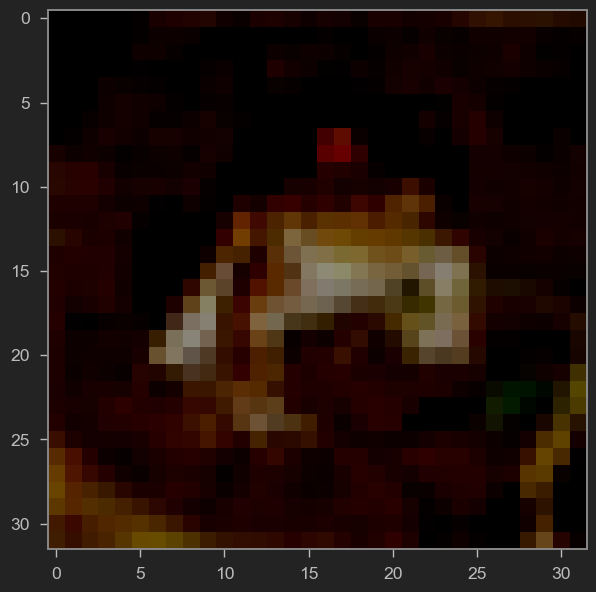

label is frog with index 6
prediction is frog with output tensor([[ 1.3665, -0.5882,  0.1332,  1.2625,  1.8794,  0.4330,  3.5173,  0.8659,
         -5.1264, -2.9051]], dtype=torch.float64, grad_fn=<AddmmBackward0>) 


In [4]:
images, labels = training_data.__getitem__(0)
testimage, testlabel = torch.unsqueeze(images, 0).to(torch.float64), torch.unsqueeze(torch.tensor(labels), 0).to(torch.float64)
imshow(images)
print("label is {} with index {}".format(classes[labels], labels))
pred = model(testimage)

print("prediction is {} with output {} ".format(classes[pred.argmax()], pred))




Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-12
Set parameter BestObjStop to value 0.001
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 13853 rows, 7710 columns and 3695161 nonzeros
Model fingerprint: 0xda6d2d0d
Model has 1 general constraint
Variable types: 6174 continuous, 1536 integer (1536 binary)
Coefficient statistics:
  Matrix range     [9e-11, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [3e-05, 1e+02]
Presolve removed 7712 rows and 31 columns (presolve time = 5s) ...
Presolve removed 7684 rows and 4 columns
Presolve time: 5.77s
Presolved: 6169 rows, 7706 columns, 3683824 nonzeros
Variable types: 6162 continuous, 1544 integer (1544 binary)

Root simplex log...

Iteration    Objective       Primal

C:\Users\Ufuk\Documents\Programming\ICNN_verification\script\Verification.py:188: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  test_inp = torch.tensor([inp], dtype=torch.float64)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3.4581366619604132
-0.9264002626894721
0.26840385899768604
-0.5032393074563615
2.383896326053552
-1.062143528371294
1.3597599582962152
-4.428115830071732
-3.1457405553773565
optimum solution with value 
 [ 3.7999479  -0.58458902  0.6102151  -0.16142807  2.72570757 -0.72033229
  0.34181124  1.7015712  -4.08630459 -2.80392931]
max_var 3.4581366619604132

time to solve 35.758737325668335 s.
tensor([[-0.4373, -0.7627, -0.7078,  ..., -0.0020, -0.2412, -0.5353]],
       dtype=torch.float64)
prediction is frog with output tensor([[ 3.7999, -0.5846,  0.6102, -0.1614,  2.7257, -0.7203,  0.3418,  1.7016,
         -4.0863, -2.8039]], dtype=torch.float64, grad_fn=<AddmmBackward0>) 


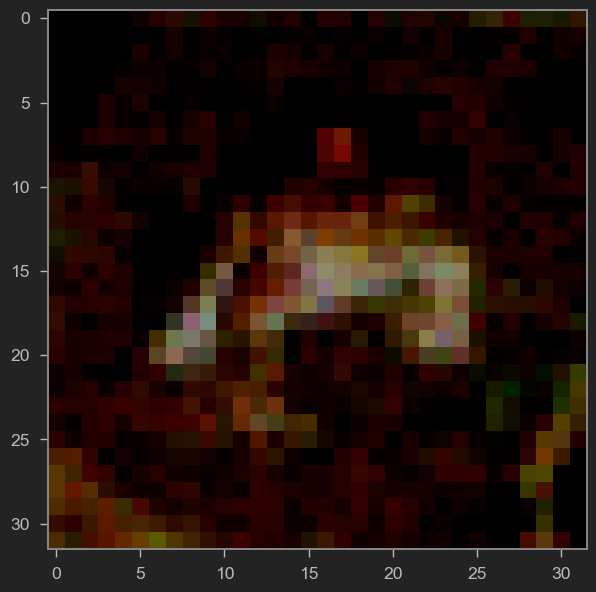

In [5]:
print("=================")
start = time.time()
alt_pic, alt_out = verification_of_normal(model, images, labels, eps=0.1, bound=0+0.001)
end = time.time() - start
print("=================")
print("")
print("time to solve {} s.".format(end))
print(alt_pic)
out = model(alt_pic)
print("prediction is {} with output {} ".format(classes[pred.argmax()], out))

reshaped = np.reshape(alt_pic, (3, 32, 32))
imshow(reshaped)